In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib
from sklearn.cluster import KMeans
import xarray as xr

import common.loss_utils as loss_utils
import common.climatehack_dataset as climatehack_dataset 

import sys
sys.path.append('./dgmr')
import dgmr


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
FORECAST = 24
INPUT_STEPS = 4
BATCH_SIZE = 16

In [5]:
p = pathlib.Path('data/data_random_300.npz')
f = np.load(p)
times = f['times']
data = f['data']

In [6]:
times.shape, data.shape

((18354,), (18354, 325, 400))

In [7]:
def check_times(tstart, tend):
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

_MEDIAN_PIXEL = 212.0
_IQR = 213.0

def transform(x):
    return np.tanh((x - _MEDIAN_PIXEL) / _IQR)

class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, times, data, random_state=7):
        self.times = times
        self.data = data
        self.generator = np.random.RandomState(random_state)

    def _get_crop(self, input_slice, target_slice):
        # roughly over the mainland UK
        rand_x = self.generator.randint(0, input_slice.shape[2] - 128)
        rand_y = self.generator.randint(0, input_slice.shape[1] - 128)

        # make a data selection
        in_crop = input_slice[:, rand_y : rand_y + 128, rand_x : rand_x + 128]
        target_crop = target_slice[
            :, rand_y + 32 : rand_y + 96, rand_x + 32 : rand_x + 96
        ]

        return in_crop, target_crop

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((index + 35) % len(self))
        src = data[index+12-INPUT_STEPS:index+12]
        trg = data[index+12:index+36]
        x, y = self._get_crop(src, trg)
        x = transform(x)
        y = transform(y)
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = CustomTensorDataset(times, data)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=4,
    prefetch_factor=4
)


In [8]:
x, y = ds[0]

In [9]:
x.shape, y.shape

((4, 128, 128), (24, 64, 64))

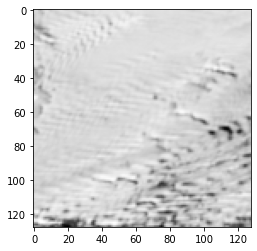

In [10]:
plt.imshow(x[-1], cmap='gray')

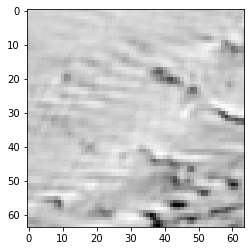

In [11]:
plt.imshow(y[0], cmap='gray')

In [12]:
model = dgmr.DGMR(
    forecast_steps=FORECAST,
    input_channels=1,
    output_shape=128,
    latent_channels=384,
    context_channels=192,
    num_samples=3,
)
model = model.to(DEVICE)
model.load_state_dict(torch.load('weights/300d_dgmr/dgmr_epochs=51_batch=299_loss=0.0376.pt'))

<All keys matched successfully>

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')

The model has 58104267 trainable parameters


In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # 1e-3
mse_criterion = torch.nn.MSELoss()

In [15]:
def train_epoch(model, epoch, dl, optimizer, criterion):
    model.train()
    final_layer = torch.nn.AvgPool2d(kernel_size=2)

    epoch_loss = 0
    total_count = 0
    optimizer.zero_grad()
    pbar = tqdm.tqdm(dl)
    for i, (srcs, trgs) in enumerate(pbar):
        x = srcs.float().to(DEVICE)
        y = trgs.float().to(DEVICE)
        # add a dimension because 1D image
        x = torch.unsqueeze(x, dim=2)
        y = torch.unsqueeze(y, dim=2)

        preds = model(x)
        b, t, c, h, w = preds.shape
        preds = preds.reshape(b, t*c, h, w)
        preds = final_layer(preds)
        preds = preds.reshape(b, t, c, preds.shape[-2], preds.shape[-1])
        # put in range [0, 1]
        preds = torch.tanh(preds)
        preds = (preds + 1)/2
        y = (y + 1)/2
        loss = criterion(preds, y).mean()
        try:
            loss.backward()
        except RuntimeError as re:
            return preds, y
            if "Function 'PowBackward1' returned nan values" in str(re):
                print('bad grad')
                optimizer.zero_grad()
                continue
        optimizer.step()
        optimizer.zero_grad()

        ls = loss.item()
        epoch_loss += ls
        total_count += 1
        if i % 1 == 0:
            ls = round(ls, 4)
            avg_loss = round(epoch_loss / total_count, 4)
            pbar.set_description(f'Avg Loss, Batch Loss: {avg_loss, ls}')
            if i % 300 == 299:
                torch.save(model.state_dict(), f'weights/300d_dgmr/dgmr_mssim_epochs={epoch}_batch={i}_loss={avg_loss}.pt')

    return epoch_loss / total_count



In [16]:
criterion = loss_utils.MS_SSIMLoss(data_range=1.0, channels=24)

In [17]:
torch.autograd.set_detect_anomaly(True)

In [18]:
EPOCHS = 100
EXISTING = 0

for i in range(EXISTING + 1, EPOCHS + 1):
    print(f"Epoch {i}")
#     avg_loss = train_epoch(model, i, dl, optimizer, mse_criterion)
    avg_loss = train_epoch(model, i, dl, optimizer, criterion)
    break
    avg_loss = round(avg_loss, 4)
    torch.save(model.state_dict(), f'weights/300d_dgmr/dgmr_mssim_epochs={i}_loss={avg_loss}.pt')


Epoch 1


  0%|          | 0/1145 [00:00<?, ?it/s]/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Avg Loss, Batch Loss: (0.3839, 0.3791):   2%|▏         | 26/1145 [01:14<52:59,  2.84s/it] [W python_anomaly_mode.cpp:104] Warning: Error detected in PowBackward1. Traceback of forward call that caused the error:
  File "/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/sigaida/miniconda3/envs/climatehack/lib/py

In [19]:
preds, y = avg_loss

In [24]:
p = preds.detach().cpu().numpy()
o = y.detach().cpu().numpy()

In [25]:
np.save('p.npy', p)

In [27]:
np.save('o.npy', o)

In [28]:
out = criterion(preds, y)

In [29]:
out

tensor([0.7539, 0.3558, 0.2685, 0.4753, 0.5474, 0.0857, 0.6531, 0.4408, 0.1007,
        0.2515, 0.6692, 0.1991, 0.6504, 0.7992, 0.3415, 0.5520],
       device='cuda:0', grad_fn=<RsubBackward1>)

In [30]:
l = out.mean()

In [31]:
l

tensor(0.4465, device='cuda:0', grad_fn=<MeanBackward0>)

In [32]:
l.backward()

[W python_anomaly_mode.cpp:104] Warning: Error detected in PowBackward1. Traceback of forward call that caused the error:
  File "/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
    self.io_loop.start()
  File "/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.async

RuntimeError: Function 'PowBackward1' returned nan values in its 0th output.

In [17]:
def get_mssim(y, x, average=True):
    assert len(y.shape) == 5
    if average:
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=y.shape[1])
        return criterion(y, x)
    else:
        scores = []
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=1)
        for i in range(y.shape[1]):
            score = criterion(y[:,i:i+1], x[:,i:i+1])
            scores.append(score.item())
        return scores

In [18]:
LOOKS = int(500/BATCH_SIZE)

In [19]:
final_layer = torch.nn.AvgPool2d(kernel_size=2)
criterion = loss_utils.MS_SSIM(
    data_range=1023.0, size_average=True, win_size=3, channel=24)

scores = []
running_total = 0
running_count = 0
pbar = tqdm.tqdm(dl, total=LOOKS)
for i, (srcs, trgs) in enumerate(pbar):
    if i > LOOKS:
        break
    x = srcs.float().to(DEVICE)
    y = trgs.float().to(DEVICE)
    # add a dimension because 1D image
    x = torch.unsqueeze(x, dim=2)
    y = torch.unsqueeze(y, dim=2)
    
    with torch.no_grad():
        preds = model(x)
        
    b, t, c, h, w = preds.shape
    preds = preds.reshape(b, t*c, h, w)
    preds = final_layer(preds)
    preds = preds.reshape(b, t, c, preds.shape[-2], preds.shape[-1])
    preds = torch.tanh(preds)
    
    y = torch.atanh(y) * _IQR + _MEDIAN_PIXEL
    preds = torch.atanh(preds) * _IQR + _MEDIAN_PIXEL
    score = get_mssim(preds, y, average=False)
    scores.append(score)
    
    running_total += np.mean(score)
    running_count += 1
    
    pbar.set_description(f'Avg Score: {running_total/running_count}')
    

Avg Score: 0.7308723304886371: : 32it [00:12,  2.51it/s]                      


In [20]:
scores = np.array(scores)
scores.mean()

0.7308723304886371

In [21]:
step_dgmr = scores.mean(axis=0)
step_dgmr

array([0.81849617, 0.80642932, 0.79064868, 0.77619453, 0.76317836,
       0.75259377, 0.74353771, 0.73592286, 0.72945406, 0.72418997,
       0.72007325, 0.71578141, 0.71206142, 0.70853282, 0.70584583,
       0.70406475, 0.70263609, 0.7029392 , 0.7039811 , 0.70444644,
       0.70438203, 0.70488011, 0.70510153, 0.70556455])

In [22]:
step = np.array([0.94732114, 0.8874218 , 0.8358762 , 0.79312605, 0.75684718,
       0.7254723 , 0.71111752, 0.69969728, 0.68989919, 0.68185381,
       0.67520599, 0.66936791, 0.66448703, 0.66054242, 0.65703949,
       0.65408842, 0.65171868, 0.6504889 , 0.64866001, 0.64693765,
       0.64587313, 0.6450839 , 0.64387597, 0.64268631])

In [23]:
choice = 6
np.array(step[:choice].tolist() + step_dgmr[choice:].tolist()).mean()

0.7422046844607618

In [25]:
out = preds.detach().cpu().numpy()
true = y.detach().cpu().numpy()

out = np.squeeze(out)
true = np.squeeze(true)

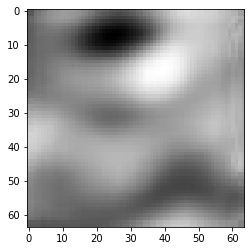

In [26]:
plt.imshow(out[0,0], cmap='gray')

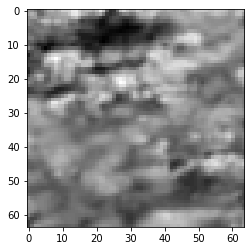

In [27]:
plt.imshow(true[0,0], cmap='gray')

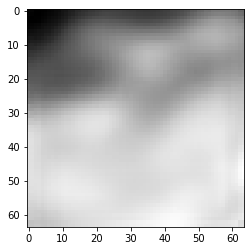

In [36]:
plt.imshow(out[10,0], cmap='gray')

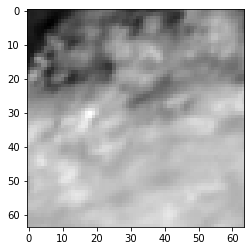

In [37]:
plt.imshow(true[10,0], cmap='gray')